In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
import torch

In [3]:
chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)} # enumerating each of the letters and making a map out of it
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}
bitoi = {}
for i in sorted(ctoi.items()):
    for j in sorted(ctoi.items()):
        bitoi[i[0] + j[0]] = i[1]*27 + j[1]

itobi = {i:bi for bi,i in bitoi.items()}

In [4]:
itobi

{0: '..',
 1: '.a',
 2: '.b',
 3: '.c',
 4: '.d',
 5: '.e',
 6: '.f',
 7: '.g',
 8: '.h',
 9: '.i',
 10: '.j',
 11: '.k',
 12: '.l',
 13: '.m',
 14: '.n',
 15: '.o',
 16: '.p',
 17: '.q',
 18: '.r',
 19: '.s',
 20: '.t',
 21: '.u',
 22: '.v',
 23: '.w',
 24: '.x',
 25: '.y',
 26: '.z',
 27: 'a.',
 28: 'aa',
 29: 'ab',
 30: 'ac',
 31: 'ad',
 32: 'ae',
 33: 'af',
 34: 'ag',
 35: 'ah',
 36: 'ai',
 37: 'aj',
 38: 'ak',
 39: 'al',
 40: 'am',
 41: 'an',
 42: 'ao',
 43: 'ap',
 44: 'aq',
 45: 'ar',
 46: 'as',
 47: 'at',
 48: 'au',
 49: 'av',
 50: 'aw',
 51: 'ax',
 52: 'ay',
 53: 'az',
 54: 'b.',
 55: 'ba',
 56: 'bb',
 57: 'bc',
 58: 'bd',
 59: 'be',
 60: 'bf',
 61: 'bg',
 62: 'bh',
 63: 'bi',
 64: 'bj',
 65: 'bk',
 66: 'bl',
 67: 'bm',
 68: 'bn',
 69: 'bo',
 70: 'bp',
 71: 'bq',
 72: 'br',
 73: 'bs',
 74: 'bt',
 75: 'bu',
 76: 'bv',
 77: 'bw',
 78: 'bx',
 79: 'by',
 80: 'bz',
 81: 'c.',
 82: 'ca',
 83: 'cb',
 84: 'cc',
 85: 'cd',
 86: 'ce',
 87: 'cf',
 88: 'cg',
 89: 'ch',
 90: 'ci',
 91: 'cj'

In [5]:
N_trigram = torch.zeros((27*27,27), dtype = torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # for each bigram in the word w
        bi = ch1 + ch2
        ix1 = bitoi[bi]
        ix2 = ctoi[ch3]
        N_trigram[ix1, ix2] += 1

In [7]:
N_bigram = torch.zeros((27,27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]): # for each bigram in the word w
        ix1 = ctoi[ch1] # index 1
        ix2 = ctoi[ch2]
        N_bigram[ix1, ix2] += 1

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

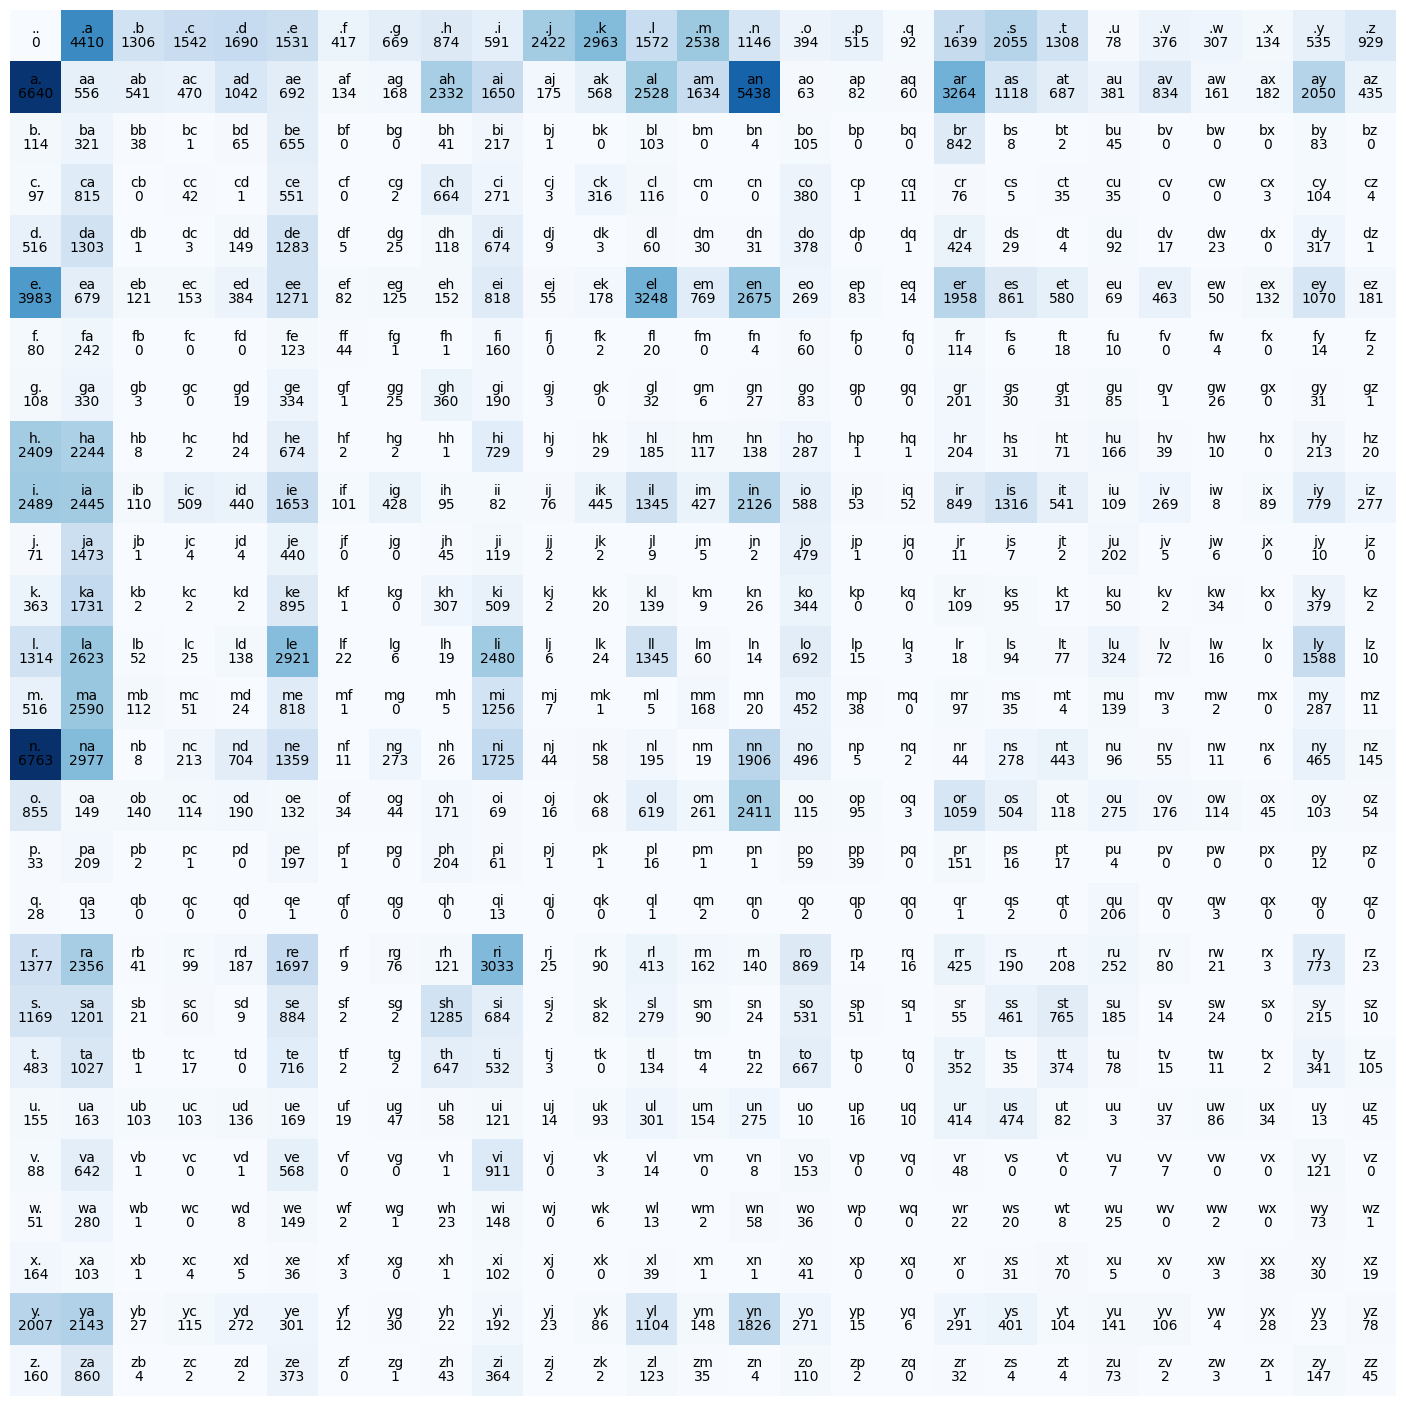

In [9]:
plt.figure(figsize=(18,18))
plt.imshow(N_bigram, cmap="Blues")

for i in range(27):
    for j in range(27):
        bigram_str = itoc[i] + itoc[j] # combine two characters to make a bigram
        plt.text(j, i, bigram_str, ha="center", va="bottom", color='black') # here, j and i represent the x and y coordinates respectively 
        plt.text(j, i, N_bigram[i,j].item(), ha="center", va="top", color='black')

plt.axis('off');

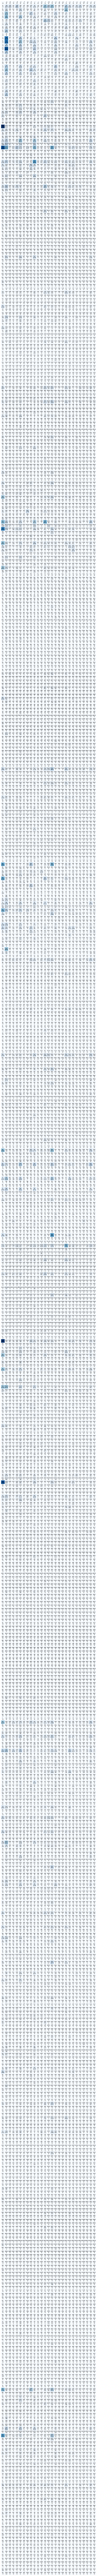

In [16]:
plt.figure(figsize=(324,324))
plt.imshow(N_trigram, cmap="Blues")

for i in range(729):
    for j in range(27):
        trigram_str = itobi[i] + itoc[j] # combine two characters to make a bigram
        plt.text(j, i, trigram_str, ha="center", va="bottom", color='black') # here, j and i represent the x and y coordinates respectively 
        plt.text(j, i, N_trigram[i,j].item(), ha="center", va="top", color='black')

plt.axis('off');

In [72]:
P_trigram = (N_trigram+1).float() # added one (a small smoothing number) to each number so that we don't end up with zero probabilities (infinte nll); called model smoothing
P_trigram.shape

torch.Size([729, 27])

In [73]:
P_trigram = P_trigram / P_trigram.sum(1, keepdims = True) # normalizing the rows;

In [74]:
P_trigram[0].sum()

tensor(1.)

In [75]:
P_bigram = (N_bigram+1).float()
P_bigram = P_bigram / P_bigram.sum(1, keepdims=True)

In [76]:
P_starting = N_trigram[1:27, 1:27].flatten().float()
P_starting[:20]

tensor([207., 190.,  31., 366.,  55.,  21.,  17.,  91., 154.,  27.,  75., 632.,
        384., 623.,  10.,  17.,   9., 482., 194.,  72.])

In [77]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):

    out = []
    index = 0
    '''for j in range(2):
        p = P_bigram[index]
        index = torch.multinomial(p, num_samples = 1, replacement=True, generator=g).item() # sampling a letter from the prob dist of p
        out.append(itoc[index])
        bi = ''.join(out)
        if index == 0:
            break'''
    index = torch.multinomial(P_starting, num_samples = 1, replacement = True, generator=g).item()
    row_index = (index // 26) + 1
    column_index = (index % 26) + 1
    bi = itoc[row_index] + itoc[column_index]
    out.append(bi[0])
    out.append(bi[1])
    while True:
            p = P_trigram[bitoi[bi]]
            index = torch.multinomial(p, num_samples = 1, replacement=True, generator=g).item() # sampling a letter from the prob dist of p
            out.append(itoc[index])
            bi = ''.join(out[-2:])
            if index == 0: 
                break # we have reached a stopping sign (.)
    print(''.join(out))

dalynliss.
on.
maaldyhersha.
ti.
kair.
aellanna.
larisen.
kamadelega.
av.
ranneyaniithn.
kamachari.
om.
dorree.
na.
er.
bel.
verai.
rayla.
ramabdido.
liah.
rhanickmnee.
virit.
ana.
rysh.
bethen.
dailentieacoll.
eldon.
alayelt.
an.
kasian.
lin.
sa.
emor.
ze.
chlon.
lee.
has.
gwelion.
elleen.
chav.
ilmkjnbet.
na.
nestin.
lin.
jm.
ny.
cas.
darisey.
anna.
linelle.


In [91]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # for each bigram in the word w
        bi = ch1 + ch2
        ix1 = bitoi[bi]
        ix2 = ctoi[ch3]
        prob = P_trigram[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{bi}{ch3}: {prob: .4f} {logprob: .4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}') # measuring the nll loss of the dataset wrt itself

log_likelihood=tensor(-410414.9688)
nll=tensor(410414.9688)
2.092747449874878


In [204]:
# create the dataset of trigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # for each bigram in the word w
        bi = ch1 + ch2
        ix1 = bitoi[bi]
        ix2 = ctoi[ch3]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs) # torch.tensor retains the datatype of xs unlike torch.Tensor which converts the input to Float
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:', num) # less trigrams in a word as compared to bigrams

# initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(729,27, generator=g, requires_grad=True)
# note that if W is all zeros, our distriution is completely smooth, i.e, all the probabilities are equal

number of examples: 196113


In [205]:
import numpy as np
import math
dataset = np.array([(x.item(), y.item()) for x, y in zip(xs,ys)])
np.random.shuffle(dataset)

In [206]:
train_cutoff = math.ceil(0.8 * num)
dev_cutoff = math.ceil(0.9 * num)
train_set = torch.tensor(dataset[:train_cutoff])
num_train = len(train_set)
devset = torch.tensor(dataset[train_cutoff: dev_cutoff])
num_dev = len(devset)
testset = torch.tensor(dataset[dev_cutoff:])
num_test = len(testset)
num_train

156891

In [207]:
import torch.nn.functional as F

In [208]:
train_set.shape, devset.shape, testset.shape

(torch.Size([156891, 2]), torch.Size([19611, 2]), torch.Size([19611, 2]))

In [222]:
# gradient descent; training stage

for k in range(100):
    # forward pass
    #xenc = F.one_hot(train_set[:,0], num_classes=729).float() # input to the network: one-hot encoded
    
    #logits = xenc @ W # predict the log-counts
    xs = train_set[:,0]
    ys = train_set[:,1]
    #logits = torch.empty((num_train, 27), dtype=torch.float32)
    logits = W[xs]
    counts = logits.exp() # counts; equivalent to N; we want it to become closer and closer to the actual counts array N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for the next character
    # the last two operations above are called 'softmax'
    #loss = -probs[torch.arange(num_train), ys].log().mean() + 0.01*(W**2).mean() # added regularization; increasing lambda corresponds to increasing X in P = (N+X).float()
    loss = F.cross_entropy(logits, ys) + 0.01*(W**2).mean()
    print(loss.item())

    # backward pass
    W.grad = None # set the gradient to zero
    loss.backward()

    # update
    W.data += -200* W.grad
    

2.0934979915618896
2.0934665203094482
2.0934360027313232
2.0934059619903564
2.0933759212493896
2.09334659576416
2.0933175086975098
2.093289613723755
2.093261480331421
2.093234062194824
2.0932068824768066
2.0931801795959473
2.093153476715088
2.093127489089966
2.093101978302002
2.093076705932617
2.0930514335632324
2.093026876449585
2.0930020809173584
2.092978000640869
2.092954397201538
2.092930793762207
2.092907428741455
2.0928845405578613
2.0928616523742676
2.092839241027832
2.0928170680999756
2.0927951335906982
2.092773199081421
2.0927517414093018
2.0927305221557617
2.092709541320801
2.092688798904419
2.092668056488037
2.0926480293273926
2.092627763748169
2.0926077365875244
2.09258770942688
2.0925679206848145
2.0925488471984863
2.092529296875
2.092510461807251
2.092491388320923
2.092472791671753
2.092454433441162
2.0924360752105713
2.0924174785614014
2.0923995971679688
2.092381715774536
2.0923640727996826
2.09234619140625
2.0923287868499756
2.092311382293701
2.092294216156006
2.0922770

In [223]:
xs = train_set[:,0]
logits = W[xs]
logits.shape

torch.Size([156891, 27])

In [224]:
# training on dev set and tuning hyperparamter lambda
for k in range(100):
    # forward pass
    #xenc = F.one_hot(devset[:,0], num_classes=729).float() # input to the network: one-hot encoded
    #logits = xenc @ W # predict the log-counts
    xs = devset[:,0]
    ys = devset[:,1]
    logits = W[xs]
    counts = logits.exp() # counts; equivalent to N; we want it to become closer and closer to the actual counts array N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for the next character
    # the last two operations above are called 'softmax'
    loss = -probs[torch.arange(num_dev), ys].log().mean() + 0.001*(W**2).mean() # added regularization; increasing lambda corresponds to increasing X in P = (N+X).float()
    print(loss.item())


    # backward pass
    W.grad = None # set the gradient to zero
    loss.backward()

    # update
    W.data += -100* W.grad

2.103764295578003
2.0990426540374756
2.0952744483947754
2.0921108722686768
2.089359760284424
2.0869083404541016
2.084686040878296
2.0826468467712402
2.0807583332061768
2.078995943069458
2.0773422718048096
2.0757827758789062
2.0743069648742676
2.072904348373413
2.0715675354003906
2.0702908039093018
2.06906795501709
2.067894458770752
2.066765785217285
2.0656790733337402
2.0646309852600098
2.0636179447174072
2.062638282775879
2.061689615249634
2.060770034790039
2.05987811088562
2.0590109825134277
2.058168411254883
2.0573482513427734
2.0565500259399414
2.055771827697754
2.055013418197632
2.0542731285095215
2.0535504817962646
2.052844762802124
2.052154541015625
2.0514800548553467
2.0508201122283936
2.0501742362976074
2.049541711807251
2.048921823501587
2.048314332962036
2.0477190017700195
2.047135591506958
2.046562910079956
2.0460004806518555
2.0454485416412354
2.0449066162109375
2.0443742275238037
2.043851137161255
2.043337106704712
2.0428314208984375
2.0423343181610107
2.0418457984924316


In [225]:
# testing on the test set once
#xenc = F.one_hot(testset[:,0], num_classes=729).float() # input to the network: one-hot encoded
xs = testset[:, 0]
ys = testset[:, 1]
logits = W[xs] # predict the log-counts
counts = logits.exp() # counts; equivalent to N; we want it to become closer and closer to the actual counts array N
probs = counts / counts.sum(1, keepdims=True) # probabilities for the next character
# the last two operations above are called 'softmax'
loss = -probs[torch.arange(num_test), ys].log().mean() + 0.001*(W**2).mean() # added regularization; increasing lambda corresponds to increasing X in P = (N+X).float()
print(loss.item())


2.1404733657836914


In [226]:
# testing on 

In [227]:
xenc.shape

torch.Size([1, 729])

In [228]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):

    out = []
    index = 0
    '''for j in range(2):
        p = P_bigram[index]
        index = torch.multinomial(p, num_samples = 1, replacement=True, generator=g).item() # sampling a letter from the prob dist of p
        out.append(itoc[index])
        bi = ''.join(out)
        if index == 0:
            break'''
    index = torch.multinomial(P_starting, num_samples = 1, replacement = True, generator=g).item()
    row_index = (index // 26) + 1
    column_index = (index % 26) + 1
    bi = itoc[row_index] + itoc[column_index]
    out.append(bi[0])
    out.append(bi[1]) # for the first two characters of the word, sample it from the known probability distribution
    while True:
        x = torch.tensor([bitoi[bi]])
        #xenc = F.one_hot(torch.tensor([bitoi[bi]]), num_classes=729).float() # input to the network: one-hot encoded
        #logits = xenc @ W # predict the log-counts
        logits = W[x]
        counts = logits.exp() # counts; equivalent to N; we want it to become closer and close
        p = counts/counts.sum(1, keepdims=True)
        index = torch.multinomial(p, num_samples=1, replacement = True, generator=g).item()
        out.append(itoc[index])
        bi = ''.join(out[-2:])
        if index == 0: 
            break # we have reached a stopping sign (.)
    print(''.join(out))

dalialiss.
on.
maaldys.
phidele.
kair.
aellanna.
larisefaraaniyan.
arukhlbare.
li.
swan.
kamachari.
om.
dorren.
na.
er.
bel.
verai.
rayla.
ramaizadomilin.
ma.
ehikonee.
virius.
lam.
ser.
bethen.
dailen.
ley.
aricedia.
kman.
maerse.
jasiyah.
kaydi.
emor.
ze.
chlon.
lee.
has.
gwelion.
ellian.
chav.
illiandemer.
kyesto.
nia.
eraleyania.
arley.
alen.
ja.
vaell.
demmaryala.
racena.
